# Import and Install

In [ ]:
import os
import torch, torchvision
import torch.nn as nn
from torch.nn.functional import interpolate
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from PIL import Image
from torchvision.transforms import transforms
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets and Dataloader

In [ ]:
import shutil
shutil.copytree('/content/drive/MyDrive/data/epico_seg/', './dataset/')

'./dataset/'

In [ ]:
# Setting
img_size = 224

In [ ]:
'''
Make mask images of .txt yolo labels
      (((((( Validation ))))))
'''
label_list = os.listdir('/content/dataset/labels/val/')

for label in label_list:
  if label.endswith('txt'):
    img = cv2.imread('/content/dataset/images/val/'+label[:-4]+'.png')
    height, width, _ = img.shape
    mask = np.zeros((height, width), np.uint8)
    
    # find mask points
    points = []
    with open('/content/dataset/labels/val/'+label, 'r') as f:
      for line in f:
          temp_points = []
          temp = line[3:-1].split(' ')
          for i in range(0,len(temp),2):
            temp_points.append((int(float(temp[i])*width), int(float(temp[i+1])*height)))
          points.append(temp_points)

    
    for pts in points:
      pts = np.array(pts, np.uint64)
      pts = pts.reshape((-1,1,2))

      for i in range(height):
        for j in range(width):
            pt = (j, i)
            dist = cv2.pointPolygonTest(pts, pt, False)
            if dist >= 0:
                mask[i,j] = 1

    cv2.imwrite('/content/dataset/labels/val/'+label[:-4]+'.png', mask)


In [ ]:
'''
Make mask images of .txt yolo labels
      (((((( Training ))))))
'''
label_list = os.listdir('/content/dataset/labels/train/')

for label in label_list:
  if label.endswith('txt'):
    img = cv2.imread('/content/dataset/images/train/'+label[:-4]+'.png')
    height, width, _ = img.shape
    mask = np.zeros((height, width), np.uint8)
    
    # find mask points
    points = []
    with open('/content/dataset/labels/train/'+label, 'r') as f:
      for line in f:
          temp_points = []
          temp = line[3:-1].split(' ')
          for i in range(0,len(temp),2):
            temp_points.append((int(float(temp[i])*width), int(float(temp[i+1])*height)))
          points.append(temp_points)

    
    for pts in points:
      pts = np.array(pts, np.uint64)
      pts = pts.reshape((-1,1,2))

      for i in range(height):
        for j in range(width):
            pt = (j, i)
            dist = cv2.pointPolygonTest(pts, pt, False)
            if dist >= 0:
                mask[i,j] = 1

    cv2.imwrite('/content/dataset/labels/train/'+label[:-4]+'.png', mask)


In [ ]:
# write train on files
f = open("train_images.txt", "w")
for label in os.listdir('/content/dataset/labels/train/'):
  if label.endswith('png'):
    f.write(f'/content/dataset/images/train/{label}'+','+f'/content/dataset/labels/train/{label}'+'\n')


f.close()

# write val on files
f = open("test_images.txt", "w")
for label in os.listdir('/content/dataset/labels/val/'):
  if label.endswith('png'):
    f.write(f'/content/dataset/images/val/{label}'+','+f'/content/dataset/labels/val/{label}'+'\n')


f.close()

In [ ]:
# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, file_path):
        # Read the image file paths and labels from the specified text file
        with open(file_path, 'r') as f:
            self.images = []
            self.masks = []
            for line in f:
                image_file, mask_file = line.strip().split(',')
                self.images.append(image_file)
                self.masks.append(mask_file)

        # Define the data transforms
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Define the data transforms
        self.transform_mask = transforms.Compose([
            transforms.Resize((img_size, img_size), PIL.Image.NEAREST),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load the image and mask, apply transforms
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx]).convert('L')

        # Make 3 dim for each class
        mask = np.array(mask)
        expanded_mask = np.zeros((2,mask.shape[0],mask.shape[1]), np.float32)
        expanded_mask[0,mask == 0] = 1
        expanded_mask[1,mask == 1] = 1
        

        # Transorm data
        image = self.transform(image)
        expanded_mask = torch.from_numpy(expanded_mask)
        expanded_mask = self.transform_mask(expanded_mask)

        
        return {'image': image, 'mask': expanded_mask, 'mask_path': self.masks[idx], 'img_path': self.images[idx]}

# Define the dataloaders
train_dataset = MyDataset('/content/train_images.txt')
test_dataset = MyDataset('/content/test_images.txt')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# Swin-UnetR

In [ ]:
# import torchvision 
import swin_transformer as st
from swin_transformer import Swinm_T_Weights

In [ ]:
swin_t = st.swinm_t(weights=Swinm_T_Weights.DEFAULT)

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = x
        identity = self.conv_skip(identity)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


In [ ]:
class SwinUNetR(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = swin_t

        # Decoder 0
        self.res_0 = ResidualBlock(768, 768)
        self.dec_0 = nn.Sequential(
                        nn.ConvTranspose2d(768, 768, kernel_size=2, stride=2),
                        nn.Conv2d(768, 384, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                     )

        # Decoder 1
        self.res_1_0 = ResidualBlock(384, 384)
        self.res_1_1 = ResidualBlock(768, 384)
        self.dec_1 = nn.Sequential(
                        nn.ConvTranspose2d(384, 384, kernel_size=2, stride=2),
                        nn.Conv2d(384, 192, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                     )
        
        # Decoder 2
        self.res_2_0 = ResidualBlock(192, 192)
        self.res_2_1 = ResidualBlock(384, 192)
        self.dec_2 = nn.Sequential(
                        nn.ConvTranspose2d(192, 192, kernel_size=2, stride=2),
                        nn.Conv2d(192, 96, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                     )
        
        # Decoder 3
        self.res_3_0 = ResidualBlock(96, 96)
        self.res_3_1 = ResidualBlock(192, 96)
        self.dec_3 = nn.Sequential(
                        nn.ConvTranspose2d(96, 96, kernel_size=4, stride=4),
                        nn.Conv2d(96, 48, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                     )
        
        # Final
        self.final = nn.Sequential(
                        # ResidualBlock(48, 4)
                        nn.Conv2d(48, 24, kernel_size=3, stride=1, padding=1),
                        nn.Conv2d(24, 2 , kernel_size=3, stride=1, padding=1),
        
                     )
        


    def forward(self, x):
        # Encoder
        _, feature_dict = self.encoder(x)

        # decoder stage ((0))
        out       = self.res_0(feature_dict[6])
        out       = self.dec_0(out)
        # print("Stage zero : ", out.shape)

        # decoder stage ((1))
        skip_out  = self.res_1_0(feature_dict[4])
        out       = torch.cat([skip_out, out], dim=1)
        out       = self.res_1_1(out)
        out       = self.dec_1(out)
        # print("Stage one  : ", out.shape)

        # decoder stage ((2))
        skip_out  = self.res_2_0(feature_dict[2])
        out       = torch.cat([skip_out, out], dim=1)
        out       = self.res_2_1(out)
        out       = self.dec_2(out)
        # print("Stage one  : ", out.shape)

        # decoder stage ((3))
        skip_out  = self.res_3_0(feature_dict[0])
        out       = torch.cat([skip_out, out], dim=1)
        out       = self.res_3_1(out)
        out       = self.dec_3(out)
        # print("Stage one  : ", out.shape)

        # Final
        out = self.final(out)
         
        return out

# swin_unetr = SwinUNetR()

# Training

In [ ]:
# model = SwinUNetR()
# Define the optimizer and loss function
import torch.optim as optim
import torch.nn.functional as F

optimizer = optim.Adam(model.parameters(), lr=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.007)

# Train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

In [ ]:
# class diceloss(torch.nn.Module):
#     def init(self):
#         super(diceloss, self).init()
#     def forward(self,pred, target):
#        smooth = 1.
#        iflat = pred.contiguous().view(-1)
#        tflat = target.contiguous().view(-1)
#        intersection = (iflat * tflat).sum()
#        A_sum = torch.sum(iflat * iflat)
#        B_sum = torch.sum(tflat * tflat)
#        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

# criterion = diceloss()



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
    
    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


criterion = FocalLoss(gamma=5, alpha=None)


In [ ]:
!pip install -U einops

In [ ]:
train_loss_list = []
test_loss_list  = []
for epoch in range(50,100):
    model.train()

    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['image'].to(device), sample['mask'].to(device)
        # data = data[:,0,:,:].unsqueeze(1)
        optimizer.zero_grad()
        # print(data.shape)
        output = model(data)
        # output = torch.nn.functional.softmax(output, dim=1)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_loss_list.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for sample in test_loader:
            data, target = sample['image'].to(device), sample['mask'].to(device)
            # data = data[:,0,:,:].unsqueeze(0)
            # print(data.shape)
            output = model(data)
            output = torch.nn.functional.softmax(output, dim=1)
            test_loss += criterion(output, target).item() * len(data)

        test_loss /= len(test_loader.dataset)
        print('\n ---------   Test set: Average loss: {:.4f} --------------- \n'.format(test_loss))
        test_loss_list.append(test_loss)


Train Epoch: 50 [0/605 (0%)]	Loss: 0.000511
Train Epoch: 50 [320/605 (53%)]	Loss: 0.000446

 ---------   Test set: Average loss: 0.0045 --------------- 

Train Epoch: 51 [0/605 (0%)]	Loss: 0.000428
Train Epoch: 51 [320/605 (53%)]	Loss: 0.000421

 ---------   Test set: Average loss: 0.0046 --------------- 

Train Epoch: 52 [0/605 (0%)]	Loss: 0.000427
Train Epoch: 52 [320/605 (53%)]	Loss: 0.000397

 ---------   Test set: Average loss: 0.0046 --------------- 

Train Epoch: 53 [0/605 (0%)]	Loss: 0.000457
Train Epoch: 53 [320/605 (53%)]	Loss: 0.000718

 ---------   Test set: Average loss: 0.0046 --------------- 

Train Epoch: 54 [0/605 (0%)]	Loss: 0.000309
Train Epoch: 54 [320/605 (53%)]	Loss: 0.000499

 ---------   Test set: Average loss: 0.0046 --------------- 

Train Epoch: 55 [0/605 (0%)]	Loss: 0.000439
Train Epoch: 55 [320/605 (53%)]	Loss: 0.000417

 ---------   Test set: Average loss: 0.0047 --------------- 

Train Epoch: 56 [0/605 (0%)]	Loss: 0.000351
Train Epoch: 56 [320/605 (53%)]	

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/models/dental_seg/swinunetr/100.pth')
# model.load_state_dict(torch.load('/content/drive/MyDrive/models/dental_seg/swinunetr/10.pth'))


(327, 285) (327, 285, 3)


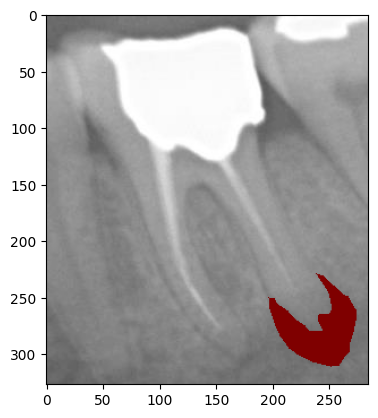

In [ ]:
'''
Check a sample image with it's label
'''
img  = cv2.imread('/content/dataset/images/val/0_0.png')
mask = cv2.imread('/content/dataset/labels/val/0_0.png',0)
print(mask.shape, img.shape)

img[mask == 1] = [127,0,0]

# plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.show()

In [ ]:
# Inference
# Define the data transforms
path_ = '/content/dataset/images/val/0_0.png'
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the test image and apply transforms
image = Image.open(path_).convert('RGB')
# from PIL import Image, ImageFilter
# image = image.filter(ImageFilter.SHARPEN)

image = transform(image).to(device)

# Load the model and set to evaluation mode
model.eval()

# Make a prediction on the input image
with torch.no_grad():
    output = model(image.unsqueeze(0))
    pred = output.argmax(dim=1, keepdim=True)

mask_pred = pred.squeeze().cpu().numpy()

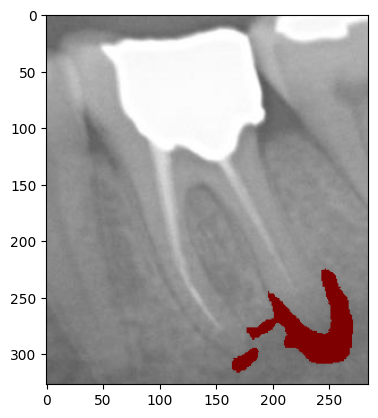

In [ ]:
org_img   = cv2.imread(path_)
mask_pred = cv2.resize(np.uint8(mask_pred), (org_img.shape[1],org_img.shape[0]))

org_img[mask_pred == 1] = [127,0,0]

plt.imshow(org_img)
plt.show()

# Plots

In [ ]:
train_loss_list_prv = list(np.load('/content/drive/MyDrive/models/dental_seg/swinunetr/train_loss_50.npy')) + train_loss_list
test_loss_list_prv = list(np.load('/content/drive/MyDrive/models/dental_seg/swinunetr/test_loss_50.npy')) + test_loss_list

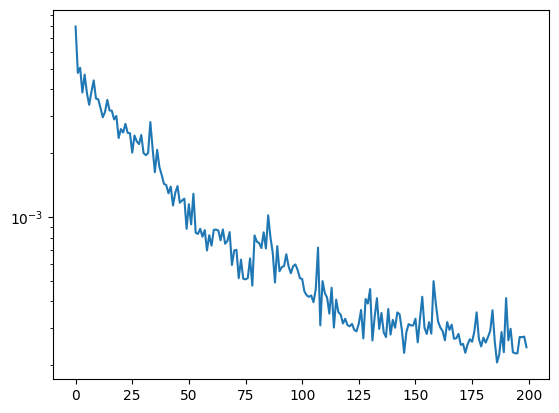

In [ ]:
plt.plot(train_loss_list_prv)
plt.yscale('log')
plt.show()


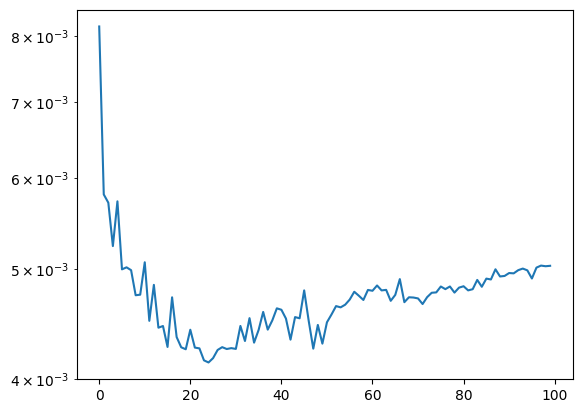

In [ ]:
plt.plot(test_loss_list_prv)
plt.yscale('log')
plt.show()


In [ ]:
np.save('/content/drive/MyDrive/models/dental_seg/swinunetr/train_loss_50.npy', train_loss_list_prv)
np.save('/content/drive/MyDrive/models/dental_seg/swinunetr/test_loss_50.npy', test_loss_list_prv)


In [ ]:
# Test model on test set and save results
model.eval()
for i in range(len(test_dataset)):
  print(i)
  image = test_dataset[i]['image'].to(device)

  with torch.no_grad():
      # Get prediction model
      output = model(image.unsqueeze(0))


      pred = output.argmax(dim=1, keepdim=True)
      mask_pred = pred.squeeze().cpu().numpy()

      # Reading images
      org_img        = cv2.imread(test_dataset[i]['img_path'])
      mask           = cv2.imread(test_dataset[i]['mask_path'],0)
      org_img_copy   = org_img.copy()
      org_img_copy_2 = org_img.copy()

      mask = cv2.resize(mask, (org_img.shape[1], org_img.shape[0]))


      # Find image + predicted mask
      mask_pred = cv2.resize(np.uint8(mask_pred), (org_img.shape[1],org_img.shape[0]))
      org_img[mask_pred == 1] = [127,0,0]
      org_img[mask_pred == 2] = [0,127,0]
      org_img[mask_pred == 3] = [0,0,127]
      
      # Find image + label
      org_img_copy[mask == 1] = [127,0,0]
      org_img_copy[mask == 2] = [0,127,0]
      org_img_copy[mask == 3] = [0,0,127]

      cv2.imwrite(f'/content/results/{i}.jpg',np.hstack((org_img_copy_2, org_img_copy, org_img)))


  # break

In [ ]:
!zip -r results_swin_100.zip ./results

# Test 

In [ ]:
import torch
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model.eval()

# Initialize the variables to compute the evaluation metrics
tp = [0] * 4
fp = [0] * 4
tn = [0] * 4
fn = [0] * 4

# Loop through the test data and calculate the confusion matrix
with torch.no_grad():
    for sample in test_loader:
        inputs, targets = sample['image'].to(device), sample['mask'].to(device)
        outputs = model(inputs)

        predicted_labels = torch.argmax(outputs, dim=1)
        gt_labels = targets.squeeze()
        gt_labels = torch.argmax(gt_labels, dim=1)   # SEt changes here 
        # print(gt_labels.shape, predicted_labels.shape);break
        # print(gt_labels, predicted_labels)
        try:
          cm = confusion_matrix(gt_labels.cpu().flatten().numpy(), predicted_labels.cpu().flatten().numpy(), labels=[0, 1, 2, 3])
        except:
          continue
        for i in range(4):
            tn[i] += sum(cm[j][k] for j in range(4) if j != i for k in range(4) if k != i)
            fp[i] += sum(cm[j][i] for j in range(4) if j != i)
            fn[i] += sum(cm[i][j] for j in range(4) if j != i)
            tp[i] += cm[i][i]


# Calculate the evaluation metrics for each class
precision = [0] * 4
sensitivity = [0] * 4
specificity = [0] * 4
f1_score = [0] * 4
avd = [0] * 4
for i in range(4):
    precision[i] = tp[i] / (tp[i] + fp[i])
    sensitivity[i] = tp[i] / (tp[i] + fn[i])
    specificity[i] = tn[i] / (tn[i] + fp[i])
    f1_score[i] = 2 * (precision[i] * sensitivity[i]) / (precision[i] + sensitivity[i])
    avd[i] = (fp[i] + fn[i]) / (fp[i] + fn[i] + tp[i] + tn[i])

# Print the results
print('Precision   :', precision)
print('Sensitivity :', sensitivity)
print('Specificity :', specificity)
print('F1-score    :', f1_score)
print('avd         :', avd)

print('')
# Print the results
print('Precision   :', np.mean(precision))
print('Sensitivity :', np.mean(sensitivity))
print('Specificity :', np.mean(specificity))
print('F1-score    :', np.mean(f1_score))
print('avd         :', np.mean(avd))


Precision   : [0.9951126504096122, 0.7756485042431035, 0.9202746412322321, 0.8975888451035513]
Sensitivity : [0.9964061393641961, 0.7219824863798802, 0.8816128723659926, 0.8715883696473758]
Specificity : [0.8231250431108352, 0.9980190906497994, 0.9993681453894505, 0.9990643591648741]
F1-score    : [0.9957589748271779, 0.7478539629008619, 0.9005289882964767, 0.8843975511267421]
avd         : [0.008259054927806857, 0.00457473267585132, 0.0015980444321100197, 0.002123840125026956]

Precision   : 0.8971561602471249
Sensitivity : 0.8678974669393611
Specificity : 0.9548941595787398
F1-score    : 0.8821348692878146
avd         : 0.004138918040198789


In [ ]:
test_loader_2 = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


In [ ]:
import torch
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model.eval()

# Initialize the variables to compute the evaluation metrics
tp = [0] * 4
fp = [0] * 4
tn = [0] * 4
fn = [0] * 4

# Loop through the test data and calculate the confusion matrix
with torch.no_grad():
    for sample in test_loader_2:
        inputs, targets = sample['image'].to(device), sample['mask'].to(device)

        image = Image.open(sample['img_path'][0]).convert('RGB')
        image = transform(image).to(device)
        with torch.no_grad():
            output = model(image.unsqueeze(0))['out']

        # outputs = model(inputs)['out']
        image = cv2.imread(sample['img_path'][0])
        image = cv2.resize(image, (224,224))
        predicted_labels  = apply_crf(image, torch.nn.functional.softmax(output, dim=1)[0].cpu().numpy())
        predicted_labels = predicted_labels.unsqueeze(0)
        gt_labels = targets.squeeze()
        gt_labels = torch.argmax(gt_labels, dim=0)   # SEt changes here 
        gt_labels = gt_labels.unsqueeze(0)

        gt_labels = gt_labels.squeeze()
        predicted_labels = predicted_labels.squeeze()

        # print(torch.max(predicted_labels), torch.max(gt_labels))

        try:
          cm = confusion_matrix(gt_labels.cpu().flatten().numpy(), predicted_labels.cpu().flatten().numpy(), labels=[0, 1, 2, 3])
        except:
          continue
        for i in range(4):
            tn[i] += sum(cm[j][k] for j in range(4) if j != i for k in range(4) if k != i)
            fp[i] += sum(cm[j][i] for j in range(4) if j != i)
            fn[i] += sum(cm[i][j] for j in range(4) if j != i)
            tp[i] += cm[i][i]


# Calculate the evaluation metrics for each class
precision = [0] * 4
sensitivity = [0] * 4
specificity = [0] * 4
f1_score = [0] * 4
for i in range(4):
    precision[i] = tp[i] / (tp[i] + fp[i])
    sensitivity[i] = tp[i] / (tp[i] + fn[i])
    specificity[i] = tn[i] / (tn[i] + fp[i])
    f1_score[i] = 2 * (precision[i] * sensitivity[i]) / (precision[i] + sensitivity[i])

# Print the results
print('Precision:', precision)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('F1-score:', f1_score)

# Print the results
print('Precision:', np.mean(precision))
print('Sensitivity:', np.mean(sensitivity))
print('Specificity:', np.mean(specificity))
print('F1-score:', np.mean(f1_score))


In [ ]:
88 87 95 87

# ROC Curve

In [ ]:
########
s_class = 1
'''
0 -> Background
1 -> Cirrus
2 -> Spectrials
3 -> TopCon
'''

########

import torch
import numpy
from sklearn.metrics import confusion_matrix

test_loader_2 = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Set the model to evaluation mode
model.eval()

# Loop through the test data and calculate the confusion matrix
threshs = numpy.linspace(0, 1, num=25)
fpr_list = []
tpr_list = []
for idx, thresh in enumerate(threshs):
  print(idx,thresh)
  tp, fp, tn ,fn = 0,0,0,0
  with torch.no_grad():
      o = 0
      for sample in test_loader_2:
          # print(o,len(test_loader_2))
          o += 1
          inputs, targets = sample['image'].to(device), sample['mask'].to(device)
          targets = targets[:,s_class,:,:]

          outputs = model(inputs)
          outputs = outputs[:,s_class,:,:]

          outputs -= torch.min(outputs);outputs /= torch.max(outputs)
          outputs = torch.threshold(outputs, threshold=float(thresh), value=0.0)

          diff  = outputs - targets
          cross = outputs * targets

          tn  += torch.sum(diff == 0).cpu().detach().item()
          fn  += torch.sum(diff == -1).cpu().detach().item()
          fp  += torch.sum((diff > 0) & (cross == 0)).cpu().detach().item()
          tp  += torch.sum(cross != 0).cpu().detach().item()



  TPR = tp / (tp + fn)
  FPR = fp / (fp + tn)
  fpr_list.append(FPR)
  tpr_list.append(TPR)

  # print("TPR: ",TPR, "FPR: ",FPR)


0 0.0
1 0.041666666666666664
2 0.08333333333333333
3 0.125
4 0.16666666666666666
5 0.20833333333333331
6 0.25
7 0.29166666666666663
8 0.3333333333333333
9 0.375
10 0.41666666666666663
11 0.4583333333333333
12 0.5
13 0.5416666666666666
14 0.5833333333333333
15 0.625
16 0.6666666666666666
17 0.7083333333333333
18 0.75
19 0.7916666666666666
20 0.8333333333333333
21 0.875
22 0.9166666666666666
23 0.9583333333333333
24 1.0


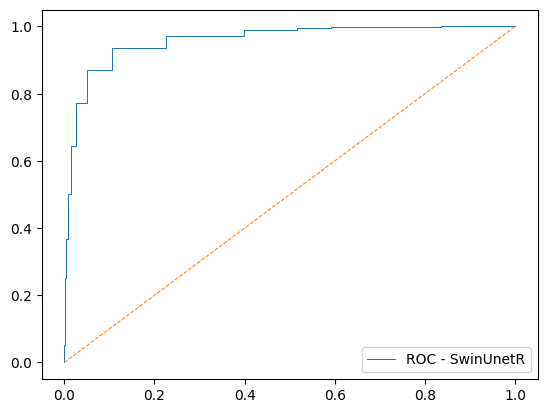

In [ ]:
import matplotlib.pyplot as plt

# plot ROC
plt.step(fpr_list, tpr_list, linewidth=0.75, label='ROC - SwinUnetR')

# Plot center line
d = numpy.linspace(0, 1, num=len(fpr_list))
plt.plot(d,d, linewidth=0.75, linestyle='--')

plt.legend()
plt.show()